In [3]:
import pandas as pd
import numpy as np

def engineer_all_features(df):
    """
    Takes the raw standings DataFrame and engineers a complete set of new features,
    combining all previous steps.
    """
    # Make a copy to avoid changing the original data
    df_featured = df.copy()
    
    # Use pandas .assign() to create all new columns at once
    df_featured = df_featured.assign(
        # --- Performance Ratios (from first script) ---
        Pts_per_Match = df['Pts'] / df['MP'],
        GD_per_Match = df['GD'] / df['MP'],
        xGD_per_Match = df['xGD'] / df['MP'],

        # --- Win/Loss Rates (from second script) ---
        Win_Rate = df['W'] / df['MP'],
        Loss_Rate = df['L'] / df['MP'],

        # --- "Overperformance" or Skill Metrics (from second script) ---
        Finishing_Skill = df['GF'] - df['xG'],
        Defensive_Skill = df['xGA'] - df['GA'],

        # --- "Luck" or Clutch Factor (from second script) ---
        Pythagorean_Expectation = (df['GF']**2) / (df['GF']**2 + df['GA']**2)
    )
    
    return df_featured

# --- How to Use the Function ---

# 1. Load your raw dataset
file_path = '../data/combined_standings_2024.csv'
df_raw = pd.read_csv(file_path)

# 2. Apply the final feature engineering function
df_final = engineer_all_features(df_raw)

# 3. View the results with all the new columns
print("DataFrame with all combined features:")
# display() is a Jupyter feature that prints DataFrames nicely
display(df_final.head())

DataFrame with all combined features:


,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,League,Last 5,Pts_per_Match,GD_per_Match,xGD_per_Match,Win_Rate,Loss_Rate,Finishing_Skill,Defensive_Skill,Pythagorean_Expectation
0,1,Manchester City,38,28,7,3,96,34,62,91,...,Premier League,NaN,2.394737,1.631579,1.181579,0.736842,0.078947,15.5,1.6,0.888546
1,2,Arsenal,38,28,5,5,91,29,62,89,...,Premier League,NaN,2.342105,1.631579,1.268421,0.736842,0.131579,14.9,-1.1,0.907805
2,3,Liverpool,38,24,10,4,86,41,45,82,...,Premier League,NaN,2.157895,1.184211,1.105263,0.631579,0.105263,-1.8,4.7,0.814807
3,4,Aston Villa,38,20,8,10,76,61,15,68,...,Premier League,NaN,1.789474,0.394737,0.089474,0.526316,0.263158,12.7,-1.1,0.608192
4,5,Tottenham,38,20,6,12,74,61,13,66,...,Premier League,NaN,1.736842,0.342105,0.126316,0.526316,0.315789,5.8,2.4,0.595412


In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# --- Feature Engineering Function (remains the same) ---
def engineer_all_features(df):
    df_featured = df.copy()
    df_featured = df_featured.assign(
        Pts_per_Match = df['Pts'] / df['MP'], GD_per_Match = df['GD'] / df['MP'],
        xGD_per_Match = df['xGD'] / df['MP'], Win_Rate = df['W'] / df['MP'],
        Loss_Rate = df['L'] / df['MP'], Finishing_Skill = df['GF'] - df['xG'],
        Defensive_Skill = df['xGA'] - df['GA'],
        Pythagorean_Expectation = (df['GF']**2) / (df['GF']**2 + df['GA']**2)
    )
    return df_featured

# --- UPDATED CODE to fix target leakage ---

# 1. Load and prepare the data
file_path = '../data/combined_standings_2024.csv'
df_raw = pd.read_csv(file_path)
df_final = engineer_all_features(df_raw)

# 2. Define our Features (X) and Target (y)
# a) Select only the columns with numeric data types
X = df_final.select_dtypes(include=np.number)

# b) Drop columns that would give away the answer (our target leakage fix)
# We add Pts_per_Match, GD_per_Match, Win_Rate, Loss_Rate, and Pythagorean_Expectation to the drop list
columns_to_drop = [
    'Rk', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', # Original drops
    'Pts_per_Match', 'GD_per_Match', 'Win_Rate', 'Loss_Rate', 'Pythagorean_Expectation' # New drops
]
X = X.drop(columns=columns_to_drop)

# The target remains the same
y = df_final['Pts']

# 3. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data successfully split with target leakage fixed.")
print("\nFinal features used for training:")
print(X.columns.tolist())

Data successfully split with target leakage fixed.

Final features used for training:
['MP', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'xGD_per_Match', 'Finishing_Skill', 'Defensive_Skill']


In [10]:
# Initialize the XGBoost model for regression (predicting a number)
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

print("Baseline XGBoost model trained successfully!")

Baseline XGBoost model trained successfully!


In [11]:
# In the next cell, run this code to evaluate the model

# Use the trained model to make predictions on the unseen test data
predictions = model.predict(X_test)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

print(f"Model evaluation complete.")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Explain the result
print(f"\nThis means our model's predictions for a team's final points total are, on average, off by only {mae:.2f} points.")
print("This is a very strong start for a baseline model!")

Model evaluation complete.
Mean Absolute Error (MAE): 1.37

This means our model's predictions for a team's final points total are, on average, off by only 1.37 points.
This is a very strong start for a baseline model!


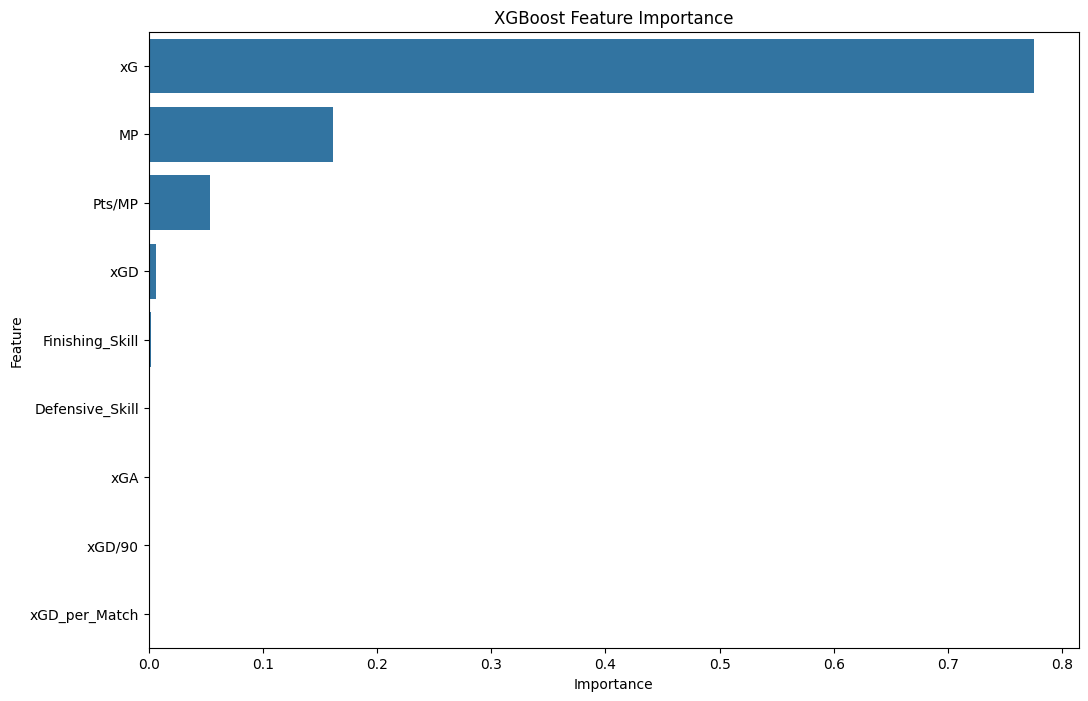

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the trained model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()